In [1]:
Image_Dataset_Path = "../input/flickr8k/Images/"
Text_Dataset_Path = '../input/flickr8k/captions.txt'

Img_Pkl = '../input/flickr8k-vgg-16-features/Image_Corpus.pkl'
TF_IDF_Corpus_Path = '../input/flickr8k-vgg-16-features/Text_Tf_Idf_Corpus.csv'

### Function to display results in a grid

In [2]:
import matplotlib.pyplot as plt
import PIL
from matplotlib import gridspec

def DisplayResults(Results, Original="", Path=Image_Dataset_Path):
    if Original != "":
        print("Searched Image :-")
        img = PIL.Image.open(Path + Original)
        fig, ax = plt.subplots()
        ax.set_axis_off()
        ax.imshow(img)
        plt.show()
    
    print("Results :-")
    columns = 5
    rows = 2

    fig = plt.figure(figsize=(60, 35))
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        img = PIL.Image.open(Path + Results[i])
        plt.imshow(img)
        plt.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.3, top=0.2, wspace=0.2, hspace=0.35)
    plt.show()

# Image Retrieval based on VGG Net

### Loading VGG Pretrained Model

In [3]:
import tensorflow as tf

input_image = tf.keras.layers.Input(shape=(224,224,3))
modelvgg = tf.keras.applications.VGG16(input_tensor=input_image)
modelvgg = tf.keras.Model(inputs=modelvgg.input, outputs=modelvgg.layers[-1].output)

## show the deep learning model
modelvgg.summary()

2022-11-09 04:24:32.932929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 04:24:32.942793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 04:24:32.943517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 04:24:32.944764: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import numpy as np

def Load_Image(name, Path=Image_Dataset_Path):
    image_path = Path + name
    img = image.load_img(image_path, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    feature = modelvgg.predict(img)
    feature = np.array(feature).flatten()
    return feature

def Load_Features(files):
    Filenames = []
    Features = []
    for file in files:
        feature = Load_Image(file)
        Filenames.append(file)
        Features.append(feature)
    Features = np.array(Features)
    return (Filenames, Features)

### Images Feature Extraction

In [5]:
import os
import pickle

Images = os.listdir(Image_Dataset_Path)

if not os.path.exists(Img_Pkl):
    Img_Pkl = 'Image_Corpus.pkl'
    Filenames, Features = Load_Features(Images)

    File = open(Img_Pkl, 'wb')

    pickle.dump((Filenames, Features), File)
    File.close()

Filenames, Features = pickle.load(open(Img_Pkl, 'rb'))

### Defining K Nearest Neighbors Model

In [6]:
from sklearn.neighbors import NearestNeighbors
KNN = NearestNeighbors(n_neighbors = 10, metric = "euclidean")
KNN.fit(Features)

NearestNeighbors(metric='euclidean', n_neighbors=10)

## Driver Function 1 : Display Images retrieved for given Image

In [7]:
def Driver_1(KNN, Filenames, Image):
    Feature = [Load_Image(Image)]
    Feature_Query = np.array(Feature)

    Result = KNN.kneighbors(Feature_Query, return_distance = False)
    Result_Names = [Filenames[id] for id in Result[0]]
    
    print("Selected Image :", Image)
    DisplayResults(Result_Names, Image)

### Defining Image Queries

In [8]:
from random import random
Image_Queries = [Images[int(random() * len(Images))], Images[int(random() * len(Images))]]
print(Image_Queries)

['3336682980_1082a66878.jpg', '2479162876_a5ce3306af.jpg']


2022-11-09 04:24:36.771735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-09 04:24:37.217911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Selected Image : 3336682980_1082a66878.jpg
Searched Image :-


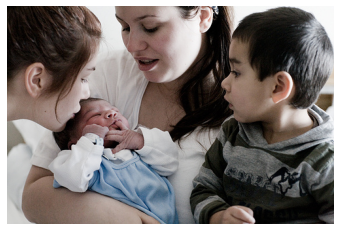

Results :-


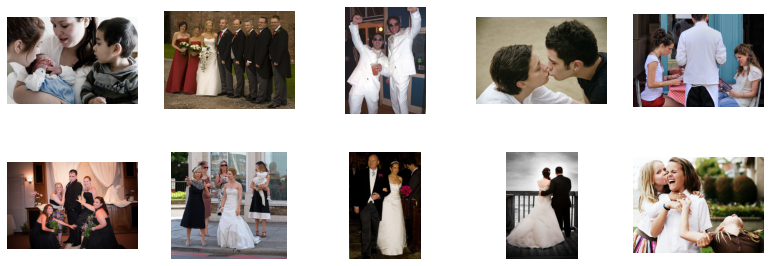

In [9]:
Driver_1(KNN, Filenames, Image_Queries[0])

Selected Image : 2479162876_a5ce3306af.jpg
Searched Image :-


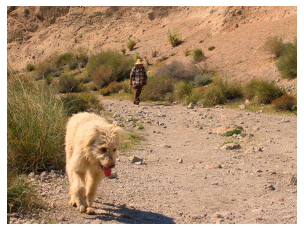

Results :-


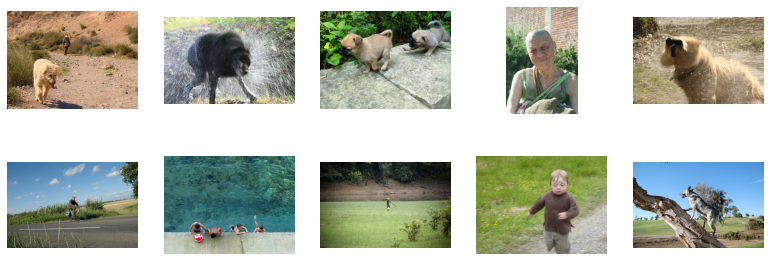

In [10]:
Driver_1(KNN, Filenames, Image_Queries[1])

# Image Retrieval based on TF-IDF Weighing Scheme

### Preprocessing the Corpus

In [11]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import string

# Function to preprocess the Corpus
def preProcessCorpus(Corpus):
    Vocabulary_Freq = {}

    Initial_Vocabulary = set()
    Vocabulary_1 = set()
    Vocabulary_2 = set()

    Lemmatizer = WordNetLemmatizer()

    for file in Corpus:
        Text = Corpus[file]

        # Tokenize the text
        Tokens = word_tokenize(Text)
        Initial_Vocabulary.update(Tokens)

        # Remove Punctuation
        Translator = str.maketrans('', '', string.punctuation)
        Tokens = [token.translate(Translator) for token in Tokens]

        # Remove Numerical Data
        Tokens = [token for token in Tokens if not token.isdigit()]

        # Remove Non-Alphabetic Tokens
        Tokens = [token for token in Tokens if token.isalpha()]

        # lowercase
        Tokens = [token.lower() for token in Tokens]
        Vocabulary_1.update(Tokens)

        # Lemmatization
        Tokens = [Lemmatizer.lemmatize(token) for token in Tokens]
        Vocabulary_2.update(Tokens)

        # Remove Stop Words
        Stop_Words = set(stopwords.words('english'))
        Tokens = [token for token in Tokens if token not in Stop_Words and token != '']

        for Token in Tokens:
            if Token not in Vocabulary_Freq:
                Vocabulary_Freq[Token] = {}
            if file not in Vocabulary_Freq[Token]:
                Vocabulary_Freq[Token][file] = 0
            Vocabulary_Freq[Token][file] += 1

    # Display Analtyics
    print("Vocabulary Size (Initial): ", len(Initial_Vocabulary))
    print("Vocabulary Size (After Normalisation): ", len(Vocabulary_1))
    print("Vocabulary Size (After Lemmatization): ", len(Vocabulary_2))
    print("Vocabulary Size (After Stop Words Removal): ", len(Vocabulary_Freq))

    return Vocabulary_Freq


def preprocessText(text):
    Freq = {}
    Lemmatizer = WordNetLemmatizer()
    Tokens = word_tokenize(text)
    Tokens = [token for token in Tokens if not token.isdigit()]
    Tokens = [token.lower() for token in Tokens]
    Tokens = [Lemmatizer.lemmatize(token) for token in Tokens]
    Stop_Words = set(stopwords.words('english'))
    Tokens = [token for token in Tokens if token not in Stop_Words and token != '']

    for Token in Tokens:
        if Token not in Freq:
            Freq[Token] = 0
        Freq[Token] += 1

    return Freq

### Calculate Term Frequency & Inverse Document Frequency Weights

In [13]:
from math import *

# Function to calculate the TF
def getTF(Vocabulary_Freq_Token, File):
    if File not in Vocabulary_Freq_Token:
        return 0
    return 1 + log2(Vocabulary_Freq_Token[File])

# Function to calculate the IDF
def getIDF(Vocabulary_Freq_Token, Total_Docs):
    return log2(Total_Docs / len(Vocabulary_Freq_Token))

### Get Ranking of Images by Cosine Similarity

In [14]:
def GetRanking(Vector_Space, Query_Vector, N=10):
    # Calculating the Cosine Similarity
    Similarity = {}
    for file in Vector_Space:
        name = Vector_Space[file]['Unnamed: 0']
        Similarity[name] = 0
        for Token in Query_Vector:
            Similarity[name] += (Vector_Space[file][Token] * Query_Vector[Token])
        Similarity[name] = Similarity[name] / (sqrt(sum([Vector_Space[file][Token] ** 2 for Token in Vocabulary_Freq])) * sqrt(sum([Query_Vector[Token] ** 2 for Token in Vocabulary_Freq])))
    
    TopN = sorted(Similarity, key=Similarity.get, reverse=True)[:N]
    return TopN

### Function to load the TF-IDF Weights

In [15]:
import pandas as pd
import random
import os

def get_TF_IDF_Corpus(TF_IDF_Corpus_Path, Vocabulary_Freq, Image_Desc):
    if not os.path.exists(TF_IDF_Corpus_Path):
        print("Creating TF IDF Weights")
        # Representing the Corpus as a Vector Space
        Vector_Space = {}
        for file in Image_Desc:
            Vector_Space[file] = {}
            for Token in Vocabulary_Freq:
                Vector_Space[file][Token] = getTF(Vocabulary_Freq[Token], file) * getIDF(Vocabulary_Freq[Token], len(Image_Desc))

        df = pd.DataFrame(Vector_Space).T

        TF_IDF_Corpus_Path = 'Text_Tf_Idf_Corpus.csv'
        df.to_csv(TF_IDF_Corpus_Path)

    
    print("TF IDF Weights Reading ...")
    df = pd.read_csv(TF_IDF_Corpus_Path)
    Vector_Space = df.T.to_dict('dict')
    print("Done")
    
    return Vector_Space

## Driver Function 2 : Display Images retrieved for given Query

In [16]:
def Driver_2(Vector_Space, Vocabulary_Freq, Query):
    # Creating Query Vector Space
    Query_Freq = preprocessText(Query)
    for Token in Vocabulary_Freq:
        Query_Freq[Token] = getTF(Query_Freq, Token) * getIDF(Vocabulary_Freq[Token], len(Vector_Space))

    Top10 = GetRanking(Vector_Space, Query_Freq)
    print("Query :", Query)
    DisplayResults(Top10)
    return Top10

In [17]:
df_Flickr = pd.read_csv(Text_Dataset_Path)

Image_Desc = {}
for index in df_Flickr.index:
    Image = df_Flickr["image"][index]
    if Image not in Image_Desc:
        Image_Desc[Image] = df_Flickr["caption"][index]
    else:
        Image_Desc[Image] +=  " " + df_Flickr["caption"][index]

Vocabulary_Freq = preProcessCorpus(Image_Desc)
Vector_Space = get_TF_IDF_Corpus(TF_IDF_Corpus_Path, Vocabulary_Freq, Image_Desc)

Vocabulary Size (Initial):  9630
Vocabulary Size (After Normalisation):  8774
Vocabulary Size (After Lemmatization):  7564
Vocabulary Size (After Stop Words Removal):  7451
TF IDF Weights Reading ...
Done


### Defining Text Queries

In [18]:
Text_Queries = ["boy running with horse", "man on a hill or mountain"]
print(Text_Queries)

['boy running with horse', 'man on a hill or mountain']


Query : boy running with horse
Results :-


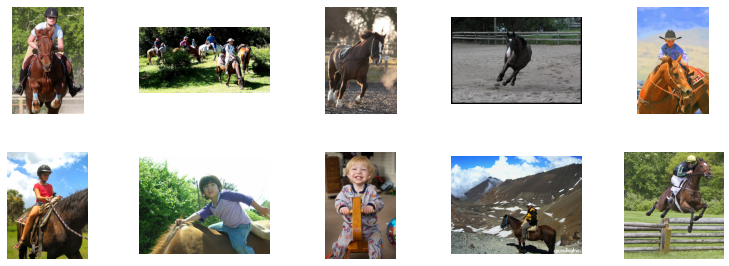

In [19]:
Ranking = Driver_2(Vector_Space, Vocabulary_Freq, Text_Queries[0])

Selected Image : 3583704941_611353857e.jpg
Searched Image :-


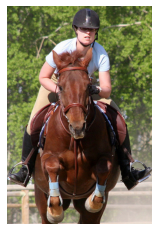

Results :-


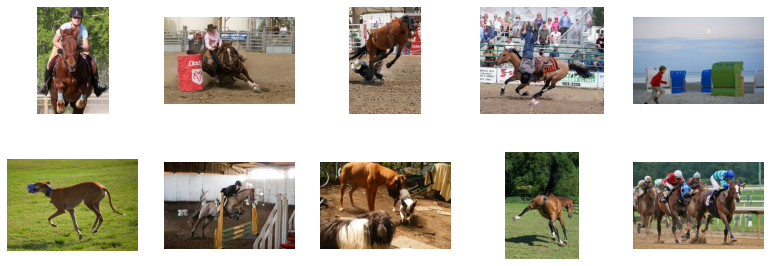

In [20]:
# Ensemble Results from Driver_2 function with Driver_1
Driver_1(KNN, Filenames, Ranking[0])

Query : man on a hill or mountain
Results :-


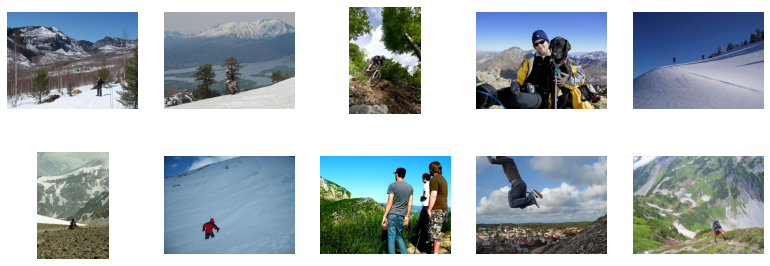

In [21]:
Ranking = Driver_2(Vector_Space, Vocabulary_Freq, Text_Queries[1])

Selected Image : 3621647714_fc67ab2617.jpg
Searched Image :-


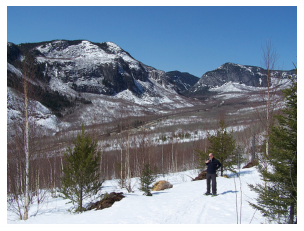

Results :-


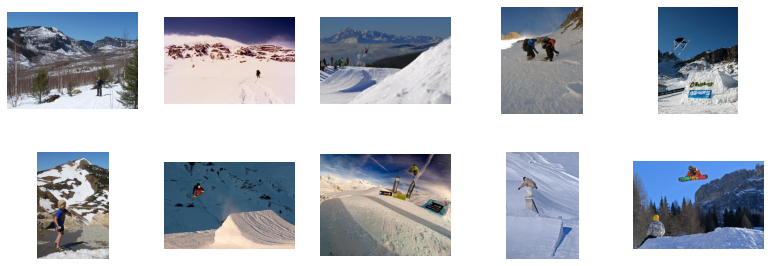

In [22]:
# Ensemble Results from Driver_2 function with Driver_1
Driver_1(KNN, Filenames, Ranking[0])

In [23]:
# Clear the GPU Memory
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7fbe56f31fb0 to Device at 0x7fbe56f329d0>

# Image Retrieval based on BERT Model

In [24]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
BERT_Model = SentenceTransformer('bert-base-nli-mean-tokens')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 951.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=642b8da411f3fcbf73c66b408064085d85d7e09a992a35b7a73adf6bcf828741
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

### Encoding the Image Captions into Embeddings

In [25]:
Images_Corpus = list(Image_Desc.keys())
Text_Corpus = list(Image_Desc.values())

Text_Embeddings = BERT_Model.encode(Text_Corpus)
print(Text_Embeddings.shape)

Batches:   0%|          | 0/253 [00:00<?, ?it/s]

(8091, 768)


## Driver Function 3 : Display Images retrieved for given Query

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def sort_list(list1, list2, rev=True):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs, reverse=rev)]
    return z

def Driver_3(BERT_Model, Text_Embeddings, Images_Corpus, Query):
    Query_Embedding = BERT_Model.encode([Query])
    Similarity = cosine_similarity(Query_Embedding, Text_Embeddings)[0]
    
    Ranking = sort_list(Images_Corpus, list(Similarity))[:10]
    print("Query :", Query)
    DisplayResults(Ranking)
    return Ranking

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query : boy running with horse
Results :-


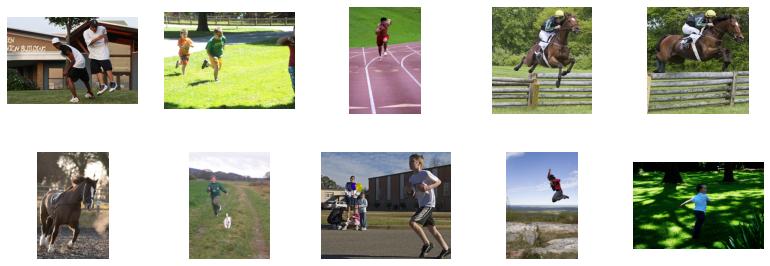

In [32]:
Ranking = Driver_3(BERT_Model, Text_Embeddings, Images_Corpus, Text_Queries[0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query : man on a hill or mountain
Results :-


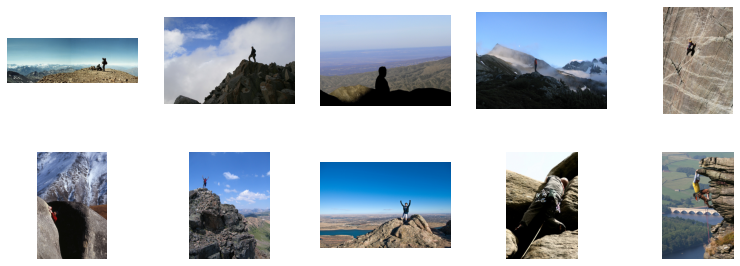

In [31]:
Ranking = Driver_3(BERT_Model, Text_Embeddings, Images_Corpus, Text_Queries[1])

## Complete